In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


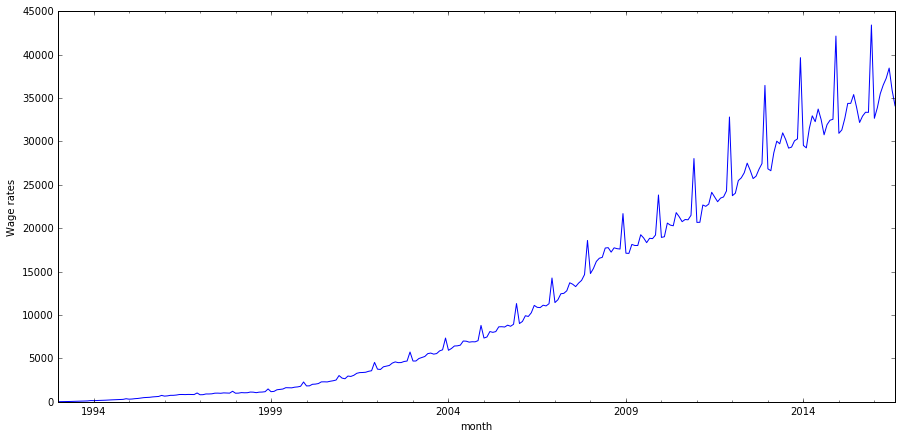

In [2]:
df = pd.read_csv('WAG_C_M.csv',';', 
                 names=['month', 'wages'], header=0,
                 index_col=['month'], 
                 parse_dates=['month'], dayfirst=True)

plt.figure(figsize(15,7))
df.wages.plot()
plt.ylabel('Wage rates')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


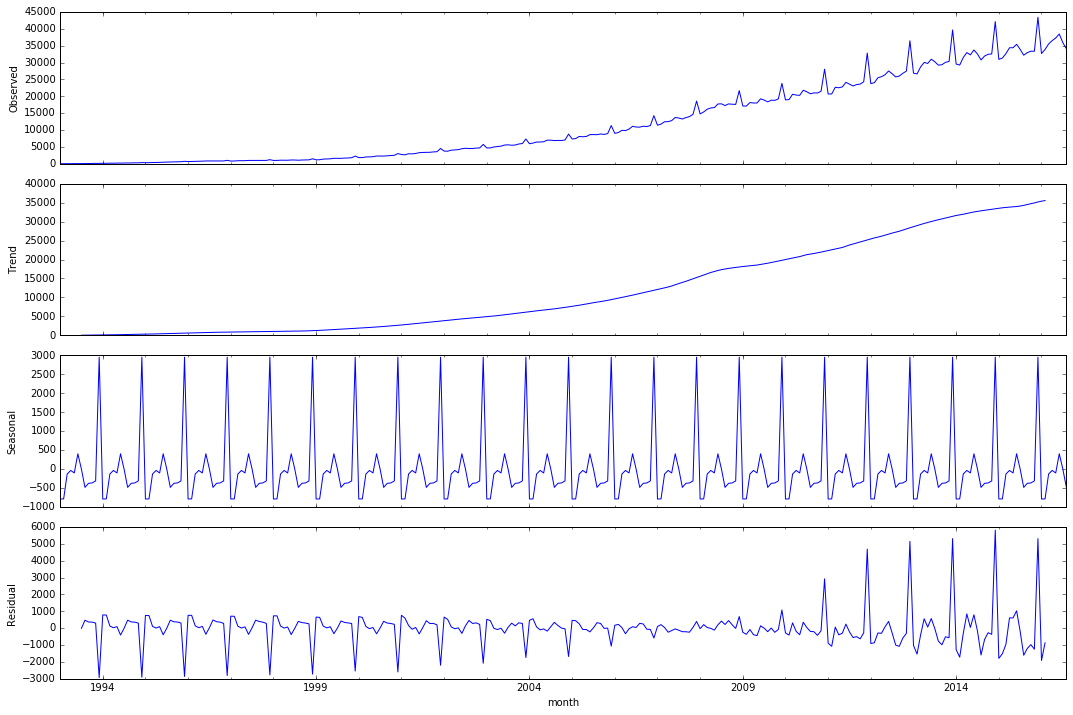

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.wages).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wages)[1])

Вывод: критерий Дики-Фуллера не отвергает гипотезу нестационарности. Возьмем больше преобразований.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


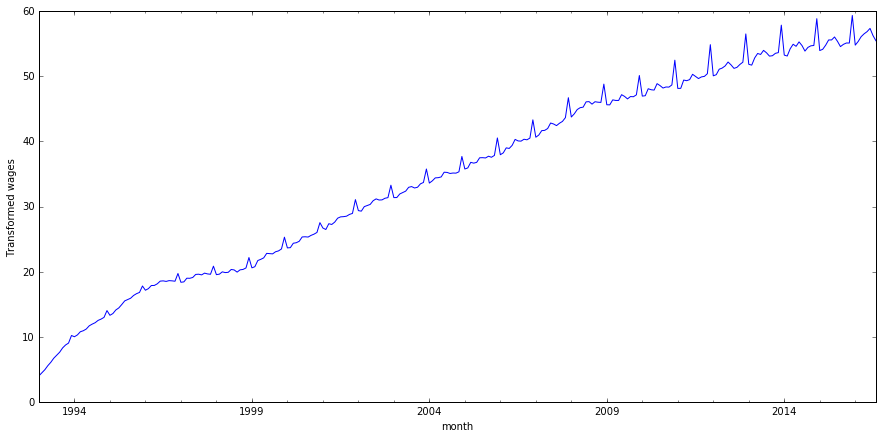

In [4]:
df['wages_box'], lmbda = stats.boxcox(df.wages)
plt.figure(figsize(15,7))
df.wages_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wages_box)[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности и визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


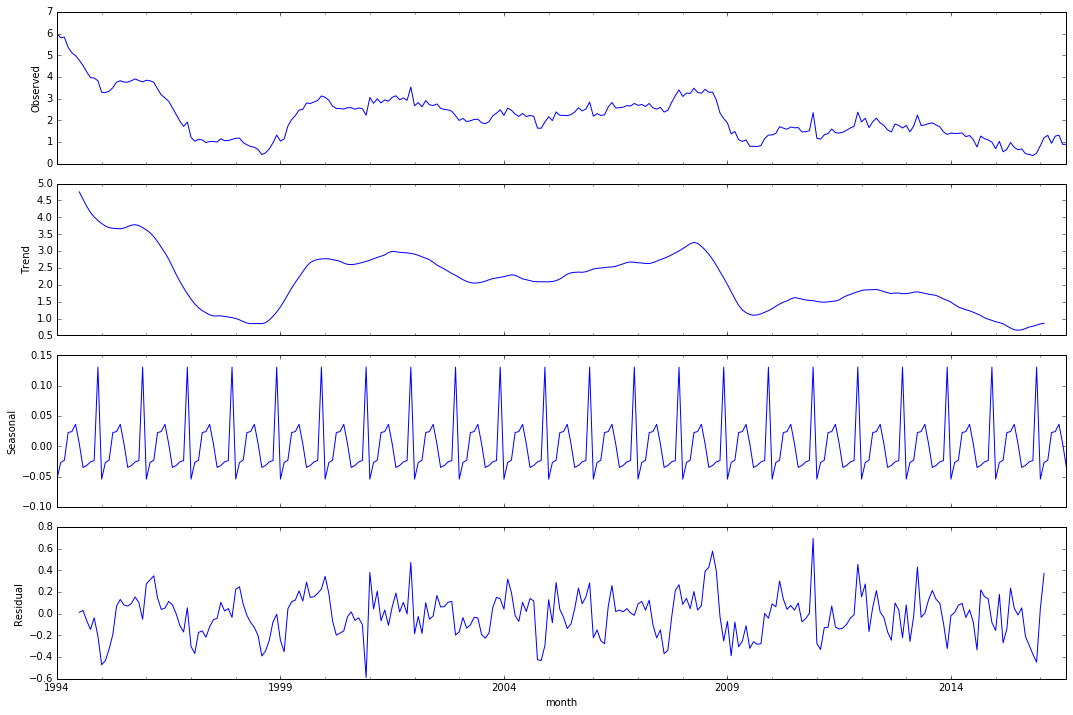

In [5]:
df['wages_box_diff'] = df.wages_box - df.wages_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.wages_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wages_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


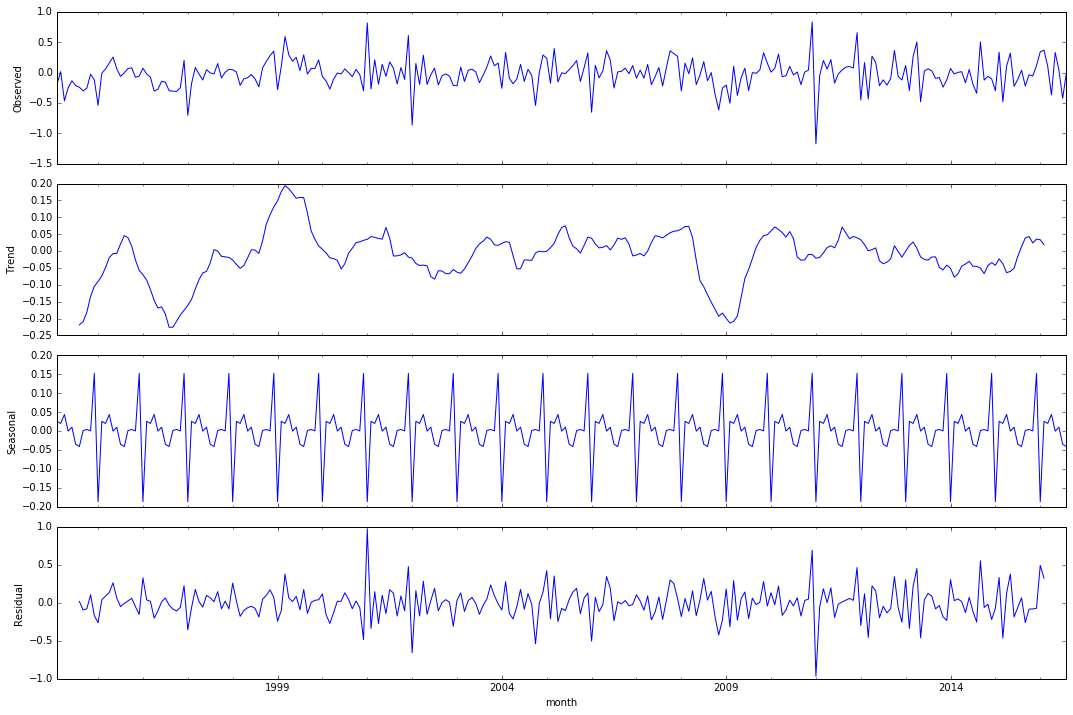

In [6]:
df['wages_box_diff2'] = df.wages_box_diff - df.wages_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.wages_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wages_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

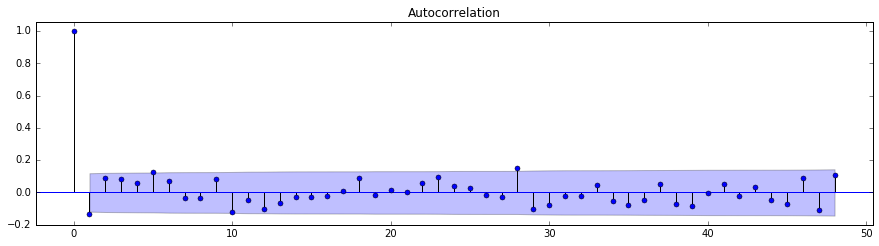

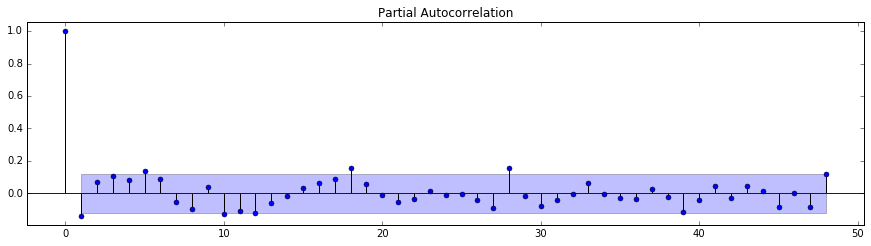

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: 
Q=0, q=5
P=0, p=5

In [8]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 1)
D=1
Qs = range(0, 1)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.wages_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 4, 0, 0)
CPU times: user 19.5 s, sys: 207 ms, total: 19.7 s
Wall time: 13.7 s


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
25  (5, 5, 0, 0) -22.462118
18  (3, 5, 0, 0) -15.248930
9   (1, 5, 0, 0) -13.661178
22  (4, 5, 0, 0) -13.617206
13  (2, 5, 0, 0) -11.940769


In [12]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          wages_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(0, 1, 0, 12)   Log Likelihood                  22.231
Date:                            Sat, 08 Oct 2016   AIC                            -22.462
Time:                                    11:12:07   BIC                             17.677
Sample:                                01-01-1993   HQIC                            -6.370
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0463     75.034      0.001      1.000    -147.017     147.110
ar.L2         -0.0097     51.467   

Критерий Стьюдента: p=0.243696
Критерий Дики-Фуллера: p=0.000000


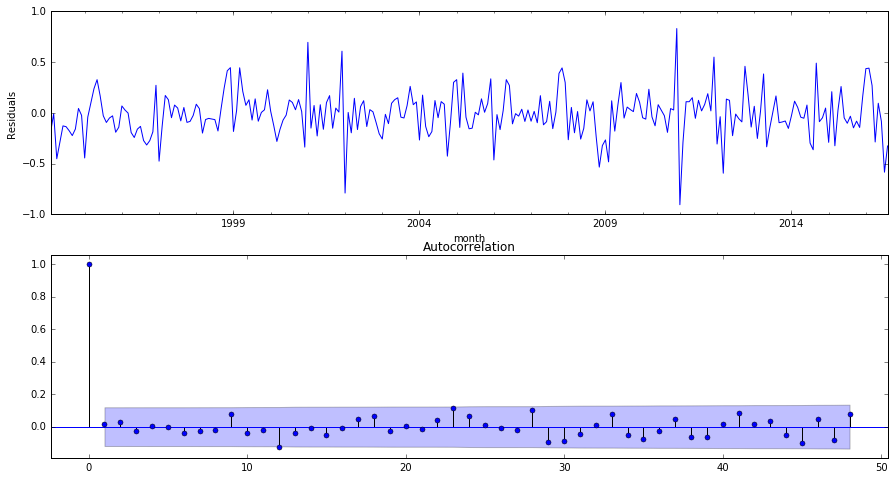

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

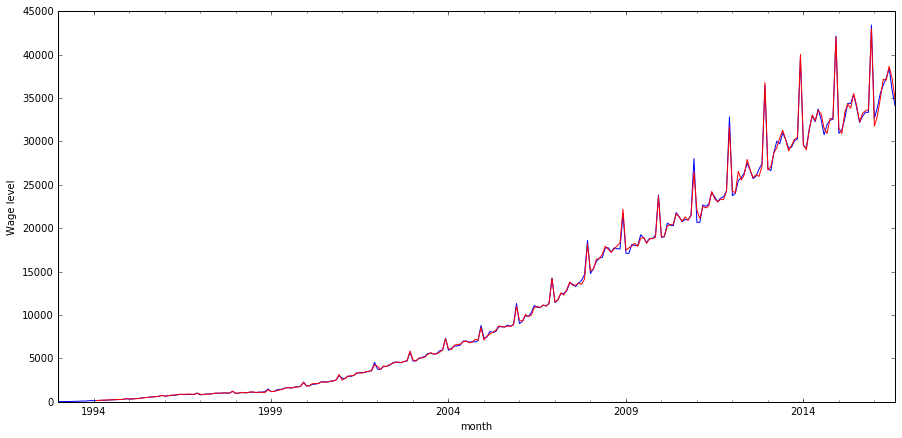

In [14]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.wages.plot()
df.model[13:].plot(color='r')
plt.ylabel('Wage level')
pylab.show()

### Прогноз

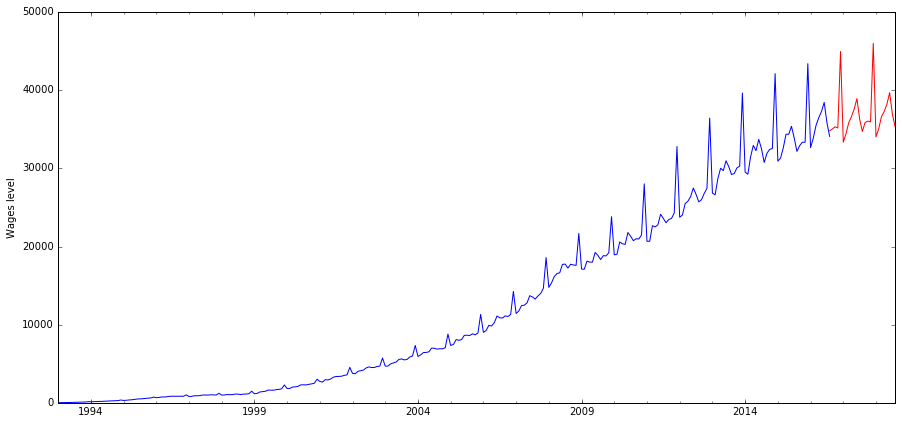

In [15]:
df2 = df[['wages']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=283, end=307), lmbda)

plt.figure(figsize(15,7))
df2.wages.plot()
df2.forecast.plot(color='r')
plt.ylabel('Wages level')
pylab.show()